In [11]:
# Import required libraries
import sys
import json
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime

sys.path.insert(0, str(Path.cwd().parent / 'utils'))

from monte_carlo import MonteCarloSimulator # type: ignore

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully")
print(f"Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Execution time: 2025-12-04 17:58:02


## Step 1: Load Historical Price Data

In [12]:
# Load historical data
bronze_file = Path.cwd().parent / 'data' / 'bronze' / 'stocks' / 'data.parquet'
df = pd.read_parquet(bronze_file)
df = df[df['Ticker'] == 'MSFT'].sort_values('date').reset_index(drop=True)

print(f"Loaded {len(df):,} records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nLatest closing price: ${df.iloc[-1]['close']:.2f}")
print(f"Date: {df.iloc[-1]['date']}")

# Display recent prices
df[['date', 'close', 'volume']].tail(10)

Loaded 1,489 records
Date range: 2020-01-02 00:00:00-05:00 to 2025-12-03 00:00:00-05:00

Latest closing price: $477.73
Date: 2025-12-03 00:00:00-05:00


,date,close,volume
1479,2025-11-19 00:00:00-05:00,486.209991,23245300
1480,2025-11-20 00:00:00-05:00,478.429993,26802500
1481,2025-11-21 00:00:00-05:00,472.119995,31769200
1482,2025-11-24 00:00:00-05:00,474.000000,34421000
1483,2025-11-25 00:00:00-05:00,476.989990,28019800
1484,2025-11-26 00:00:00-05:00,485.500000,25709100
1485,2025-11-28 00:00:00-05:00,492.010010,14386700
1486,2025-12-01 00:00:00-05:00,486.739990,23964000
1487,2025-12-02 00:00:00-05:00,490.000000,19562700
1488,2025-12-03 00:00:00-05:00,477.730011,34562900


## Step 2: Initialize Monte Carlo Simulator

In [13]:
# Initialize simulator
simulator = MonteCarloSimulator(
    num_simulations=1000,  # 1,000 simulation paths
    random_seed=42
)

print("✓ Monte Carlo simulator initialized")
print(f"  Simulations: {simulator.num_simulations:,}")
print(f"  Random seed: {simulator.random_seed}")

✓ Monte Carlo simulator initialized
  Simulations: 1,000
  Random seed: 42


## Step 3: Run Monte Carlo Simulations

Generate price forecasts for multiple time horizons: 30, 60, and 90 days

In [14]:
# Run simulations for multiple horizons
time_horizons = [30, 60, 90]  # days

results = simulator.run_simulation(
    price_history=df['close'],
    time_horizons=time_horizons,
    method='historical'  # Use historical mean and volatility
)

print("\n✓ Monte Carlo simulation completed successfully")


MONTE CARLO SIMULATION
Initial Price: $477.73
Simulations: 1,000
Horizons: [30, 60, 90] days
✓ Calculated parameters using historical method:
  Daily drift: 0.000942 (0.2375 annualized)
  Daily volatility: 0.018700 (0.2969 annualized)

Simulating 30-day forecast...

  30-Day Forecast Summary:
    Expected Price:    $491.30
    Median Price:      $489.28
    Price Range:       $348.18 - $741.63
    Expected Return:   2.84%
    Prob. of Profit:   58.8%
    VaR (5%):          -13.20%
    68% CI:            $440.85 - $538.95
    95% CI:            $400.45 - $595.92

Simulating 60-day forecast...

  60-Day Forecast Summary:
    Expected Price:    $507.75
    Median Price:      $500.26
    Price Range:       $297.95 - $895.32
    Expected Return:   6.28%
    Prob. of Profit:   62.7%
    VaR (5%):          -18.71%
    68% CI:            $431.04 - $581.61
    95% CI:            $372.42 - $684.36

Simulating 90-day forecast...

  90-Day Forecast Summary:
    Expected Price:    $521.64
    Medi

## Step 4: Analyze 30-Day Forecast

In [15]:
# Extract 30-day results
result_30d = results['30d']
stats_30d = result_30d['statistics']

print("\n" + "="*70)
print("30-DAY FORECAST ANALYSIS")
print("="*70)
print(f"Initial Price:        ${stats_30d['initial_price']:.2f}")
print(f"Expected Price:       ${stats_30d['mean']:.2f}")
print(f"Median Price:         ${stats_30d['median']:.2f}")
print(f"Price Range:          ${stats_30d['min']:.2f} - ${stats_30d['max']:.2f}")
print(f"\nExpected Return:      {stats_30d['expected_return_pct']:.2f}%")
print(f"Probability of Profit: {stats_30d['prob_profit_pct']:.1f}%")
print(f"Value at Risk (5%):   {stats_30d['var_5_pct']:.2f}%")
print(f"\n68% Confidence Interval: ${stats_30d['ci_68'][0]:.2f} - ${stats_30d['ci_68'][1]:.2f}")
print(f"95% Confidence Interval: ${stats_30d['ci_95'][0]:.2f} - ${stats_30d['ci_95'][1]:.2f}")
print("="*70)

# Price percentiles
print("\nPrice Percentiles:")
for percentile, price in stats_30d['percentiles'].items():
    print(f"  {percentile:4s}: ${price:.2f}")


30-DAY FORECAST ANALYSIS
Initial Price:        $477.73
Expected Price:       $491.30
Median Price:         $489.28
Price Range:          $348.18 - $741.63

Expected Return:      2.84%
Probability of Profit: 58.8%
Value at Risk (5%):   -13.20%

68% Confidence Interval: $440.85 - $538.95
95% Confidence Interval: $400.45 - $595.92

Price Percentiles:
  p5  : $414.65
  p10 : $430.29
  p25 : $454.85
  p50 : $489.28
  p75 : $521.91
  p90 : $557.99
  p95 : $575.83


## Step 5: Visualize Simulation Results

✓ Plot saved as 'd:\Code\ms-fabric-sell-may-buy-october\data\monte_carlo_results.png'


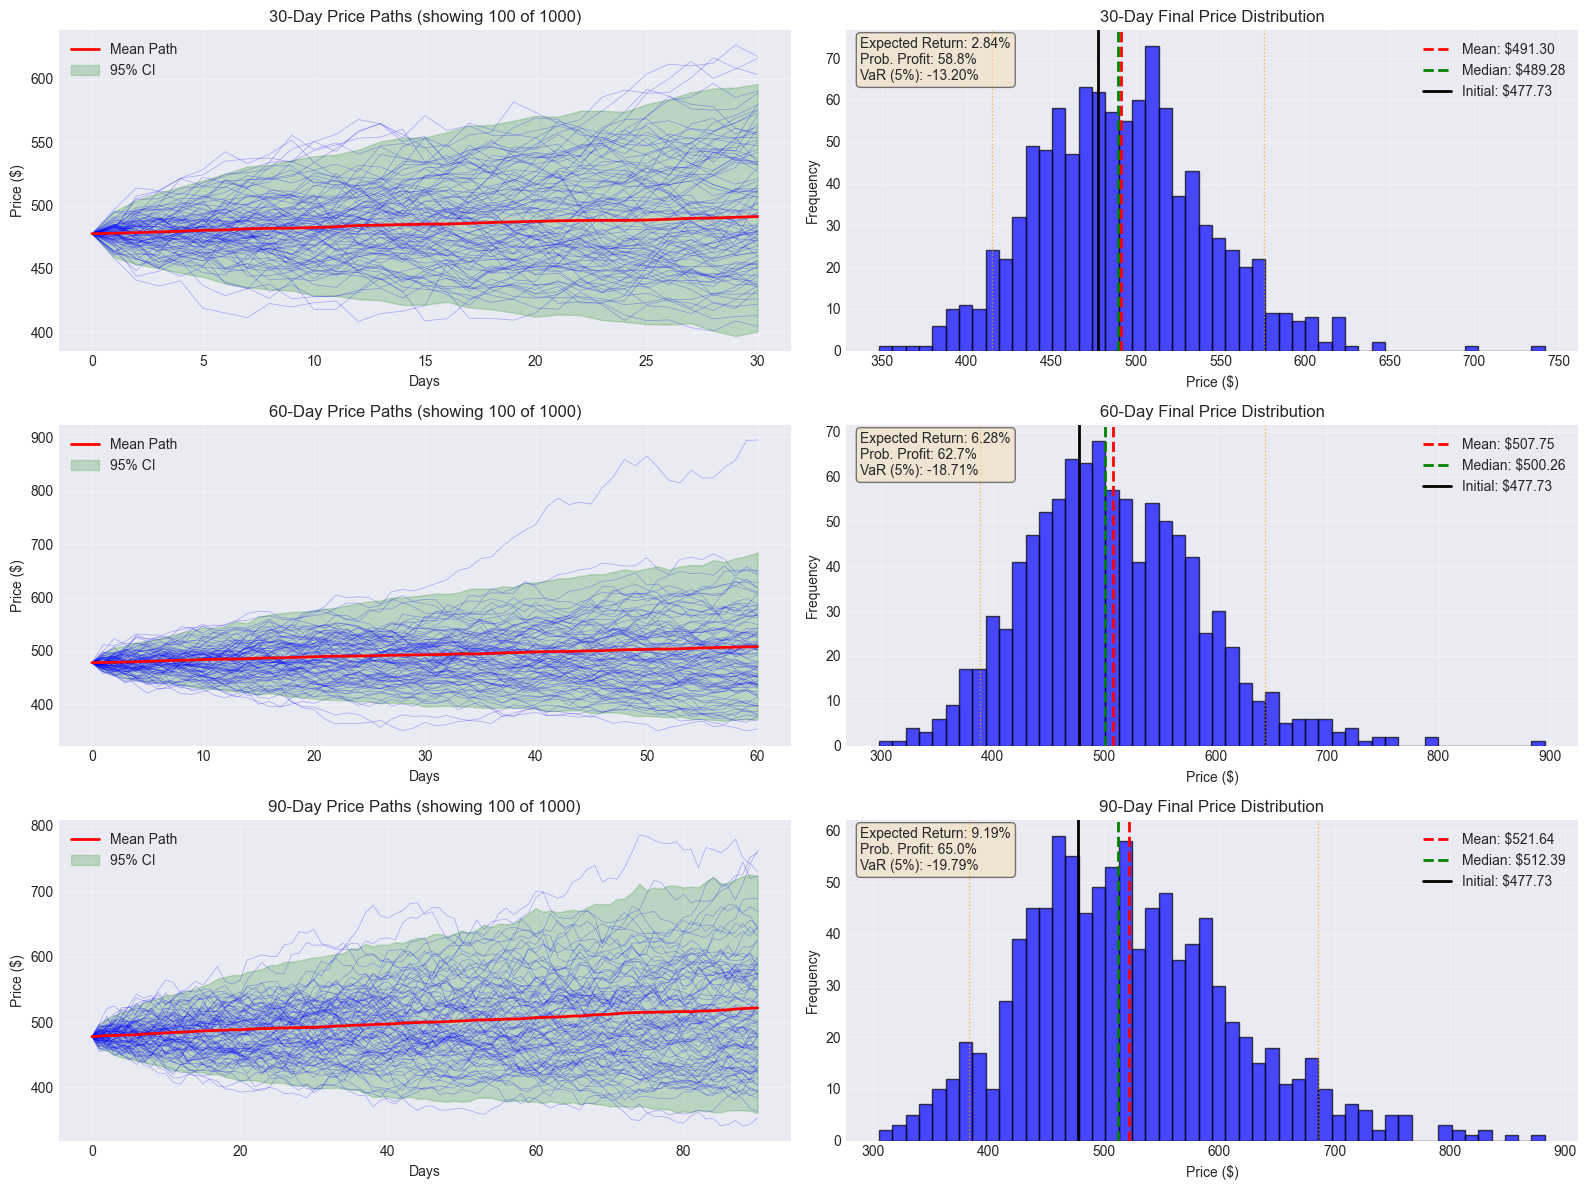

In [16]:
# Plot simulation results
simulator.plot_simulation_results(
    results=results,
    price_history=df['close'],
    show_paths=100,  # Show 100 sample paths
    figsize=(16, 12)
)

## Step 6: Summary Table for All Horizons

In [17]:
# Create summary table
summary_df = simulator.create_summary_table(results)

print("\n" + "="*120)
print("MONTE CARLO SIMULATION SUMMARY - ALL HORIZONS")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)


MONTE CARLO SIMULATION SUMMARY - ALL HORIZONS
Horizon Initial Price Expected Price Median Price Expected Return Probability of Profit VaR (5%) 95% CI Lower 95% CI Upper       Price Range
30 days       $477.73        $491.30      $489.28           2.84%                 58.8%  -13.20%      $400.45      $595.92 $348.18 - $741.63
60 days       $477.73        $507.75      $500.26           6.28%                 62.7%  -18.71%      $372.42      $684.36 $297.95 - $895.32
90 days       $477.73        $521.64      $512.39           9.19%                 65.0%  -19.79%      $360.82      $723.62 $305.44 - $882.07


## Step 7: Price Movement Classification

Classify simulation outcomes into bullish, neutral, and bearish scenarios

In [18]:
# Classify outcomes for each horizon
classification_results = {}

for horizon_key, result_data in results.items():
    horizon = result_data['horizon']
    final_prices = result_data['final_prices']
    initial_price = result_data['statistics']['initial_price']
    
    # Calculate percentage changes
    pct_changes = (final_prices - initial_price) / initial_price * 100
    
    # Classify outcomes
    bullish = (pct_changes > 5).sum()   # >5% gain
    bearish = (pct_changes < -5).sum()  # >5% loss
    neutral = len(pct_changes) - bullish - bearish
    
    classification_results[horizon_key] = {
        'horizon': horizon,
        'bullish': bullish,
        'neutral': neutral,
        'bearish': bearish,
        'bullish_pct': bullish / len(pct_changes) * 100,
        'neutral_pct': neutral / len(pct_changes) * 100,
        'bearish_pct': bearish / len(pct_changes) * 100
    }

# Display classification results
print("\n" + "="*70)
print("PRICE MOVEMENT CLASSIFICATION")
print("Bullish: >5% gain | Neutral: -5% to +5% | Bearish: >5% loss")
print("="*70)

for horizon_key, class_data in classification_results.items():
    print(f"\n{class_data['horizon']}-Day Horizon:")
    print(f"  Bullish: {class_data['bullish']:4d} ({class_data['bullish_pct']:5.1f}%)")
    print(f"  Neutral: {class_data['neutral']:4d} ({class_data['neutral_pct']:5.1f}%)")
    print(f"  Bearish: {class_data['bearish']:4d} ({class_data['bearish_pct']:5.1f}%)")

print("="*70)


PRICE MOVEMENT CLASSIFICATION
Bullish: >5% gain | Neutral: -5% to +5% | Bearish: >5% loss

30-Day Horizon:
  Bullish:  418 ( 41.8%)
  Neutral:  340 ( 34.0%)
  Bearish:  242 ( 24.2%)

60-Day Horizon:
  Bullish:  492 ( 49.2%)
  Neutral:  251 ( 25.1%)
  Bearish:  257 ( 25.7%)

90-Day Horizon:
  Bullish:  552 ( 55.2%)
  Neutral:  215 ( 21.5%)
  Bearish:  233 ( 23.3%)


## Step 8: Risk Metrics Dashboard

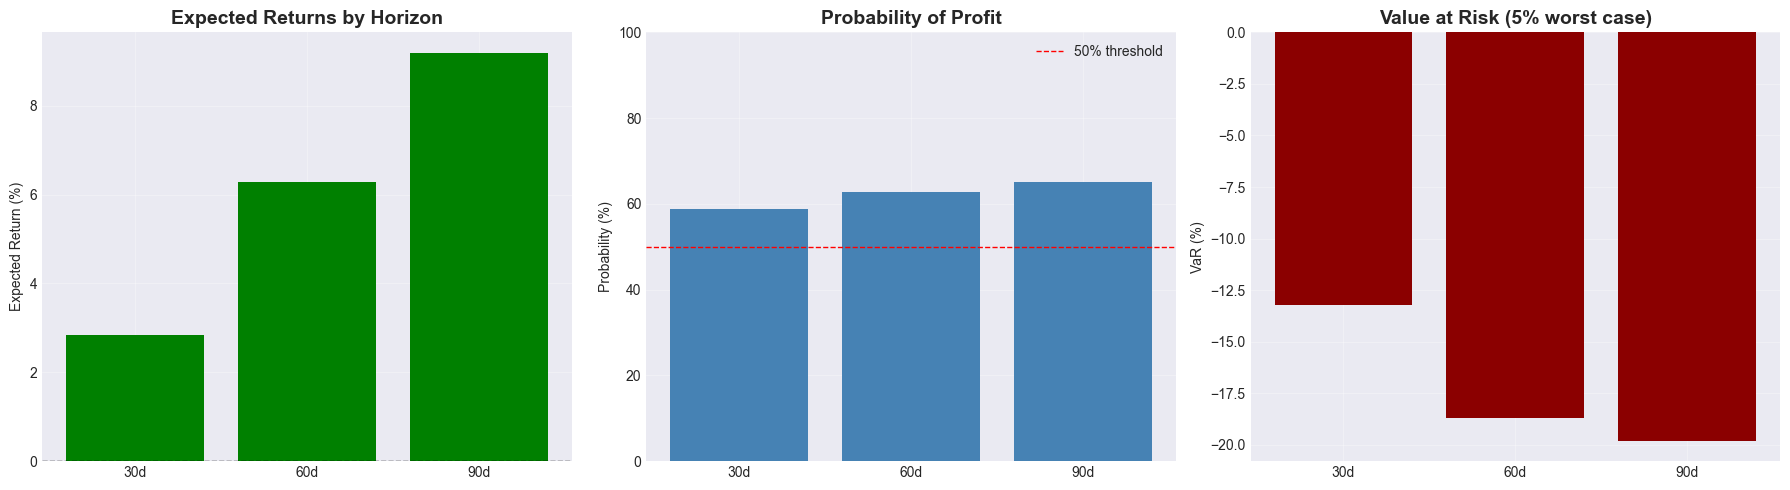

✓ Risk metrics dashboard saved


In [19]:
# Create risk metrics visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

horizons_list = [30, 60, 90]
expected_returns = [results[f'{h}d']['statistics']['expected_return_pct'] for h in horizons_list]
prob_profits = [results[f'{h}d']['statistics']['prob_profit_pct'] for h in horizons_list]
vars_5 = [results[f'{h}d']['statistics']['var_5_pct'] for h in horizons_list]

# Plot 1: Expected Returns
axes[0].bar(range(3), expected_returns, color=['green' if x > 0 else 'red' for x in expected_returns])
axes[0].set_xticks(range(3))
axes[0].set_xticklabels([f'{h}d' for h in horizons_list])
axes[0].set_title('Expected Returns by Horizon', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Expected Return (%)')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# Plot 2: Probability of Profit
axes[1].bar(range(3), prob_profits, color='steelblue')
axes[1].set_xticks(range(3))
axes[1].set_xticklabels([f'{h}d' for h in horizons_list])
axes[1].set_title('Probability of Profit', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Probability (%)')
axes[1].set_ylim(0, 100)
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Value at Risk (5%)
axes[2].bar(range(3), vars_5, color='darkred')
axes[2].set_xticks(range(3))
axes[2].set_xticklabels([f'{h}d' for h in horizons_list])
axes[2].set_title('Value at Risk (5% worst case)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('VaR (%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
risk_chart = Path.cwd().parent / 'data' / 'risk_metrics_dashboard.png'
plt.savefig(risk_chart, dpi=150, bbox_inches='tight')
plt.show()

print("✓ Risk metrics dashboard saved")

## Step 9: Save Simulation Results

In [20]:
# Save summary table
from pathlib import Path

output_dir = Path.cwd().parent / 'data' / 'gold' / 'monte_carlo'
output_dir.mkdir(parents=True, exist_ok=True)

summary_df.to_csv(output_dir / 'monte_carlo_summary.csv', index=False)

# Save classification results
classification_df = pd.DataFrame(classification_results).T
classification_df.to_csv(output_dir / 'price_classification.csv', index=False)

# Save detailed statistics
detailed_stats = {}
for horizon_key, result_data in results.items():
    detailed_stats[horizon_key] = result_data['statistics']

with open(output_dir / 'detailed_statistics.json', 'w') as f:
    json.dump(detailed_stats, f, indent=2)

print(f"\n{'='*70}")
print("MONTE CARLO SIMULATION COMPLETE")
print(f"{'='*70}")
print(f"Simulations run: {simulator.num_simulations:,}")
print(f"Horizons analyzed: {len(results)}")
print(f"Results saved to: {output_dir.name}")
print("\nKey Insights:")
print(f"  30-day expected return: {expected_returns[0]:.2f}%")
print(f"  60-day expected return: {expected_returns[1]:.2f}%")
print(f"  90-day expected return: {expected_returns[2]:.2f}%")
print("\nReady for Power BI dashboard integration")
print(f"{'='*70}")


MONTE CARLO SIMULATION COMPLETE
Simulations run: 1,000
Horizons analyzed: 3
Results saved to: monte_carlo

Key Insights:
  30-day expected return: 2.84%
  60-day expected return: 6.28%
  90-day expected return: 9.19%

Ready for Power BI dashboard integration


## Key Takeaways

### Insights from Monte Carlo Simulation:

1. **Expected Price Movement**: Based on historical volatility and drift
2. **Confidence Intervals**: 68% and 95% probability ranges for future prices
3. **Risk Assessment**: Value at Risk (VaR) shows worst-case scenarios
4. **Probability of Profit**: Likelihood of positive returns over each horizon

### Trading Implications:

- **Bullish Scenario**: If >60% simulations show profits → Consider buy signal
- **Neutral Scenario**: If 40-60% → Hold current positions
- **Bearish Scenario**: If <40% → Consider risk management strategies

**Disclaimer**: Monte Carlo simulations are based on historical data and assumptions. Past performance does not guarantee future results. Always consult with a financial advisor before making investment decisions.